# HDBSCAN Clustering for RBD sequences, MSA
---
For a baseline comparison to ESM embedded sequences, we will use multiple sequence alignment, and then use one hot to get a numerical representation. Then use tSNE+HDBSCAN just like in the ESM embedded sequence clustering.

We will take a look at values in seed 0 from the ESM RBD clustering to get the same sequence ids, first.

In [2]:
import pandas as pd

parquet_file = f"../rbd_ado/RBD.ADO.from-esm-mlm.CLS-embedded.sampled_seed0.parquet"
embedded_df = pd.read_parquet(parquet_file, engine="fastparquet")
seq_ids = set(embedded_df["seq_id"])
print(seq_ids)

{'EPI_ISL_6225372', 'EPI_ISL_12026890', 'EPI_ISL_15983644', 'EPI_ISL_1571890', 'EPI_ISL_1327615', 'EPI_ISL_4337609', 'EPI_ISL_1337506', 'EPI_ISL_7086210', 'EPI_ISL_5458577', 'EPI_ISL_14021121', 'EPI_ISL_16541828', 'EPI_ISL_2611666', 'EPI_ISL_2402414', 'EPI_ISL_4900230', 'EPI_ISL_5479663', 'EPI_ISL_6526484', 'EPI_ISL_2910855', 'EPI_ISL_1555257', 'EPI_ISL_2359840', 'EPI_ISL_5427218', 'EPI_ISL_7728499', 'EPI_ISL_6751744', 'EPI_ISL_16832965', 'EPI_ISL_2033337', 'EPI_ISL_1707045', 'EPI_ISL_5773656', 'EPI_ISL_8071097', 'EPI_ISL_16428333', 'EPI_ISL_1741170', 'EPI_ISL_7327904', 'EPI_ISL_15933877', 'EPI_ISL_7184587', 'EPI_ISL_2399400', 'EPI_ISL_2962775', 'EPI_ISL_9554626', 'EPI_ISL_6572519', 'EPI_ISL_4026051', 'EPI_ISL_2567498', 'EPI_ISL_1990556', 'EPI_ISL_7392792', 'EPI_ISL_7745334', 'EPI_ISL_6602231', 'EPI_ISL_15935719', 'EPI_ISL_1438615', 'EPI_ISL_1388649', 'EPI_ISL_8214653', 'EPI_ISL_10016855', 'EPI_ISL_2208057', 'EPI_ISL_1500090', 'EPI_ISL_1903439', 'EPI_ISL_9202364', 'EPI_ISL_16226535', '

In [9]:
# (Records only)
from Bio import AlignIO
import numpy as np

alignment = AlignIO.read("/data/spike_ml/Spike_NLP-Lightning_martha/Spike_NLP-Lightning/notebooks/phylogenetic_analysis/aligned_ADO_seq.afasta", "fasta")

# Filter records by ID
filtered_alignment = [record for record in alignment if record.id in seq_ids]

# Extract (ID, description) for each sequence
metadata = [(record.id, str(record.seq), record.description.split("|")[1].strip(), record.description.split("|")[2].strip()) for record in filtered_alignment]

# Convert to DataFrame
df = pd.DataFrame(metadata, columns=["seq_id", "seq", "variant", "pango lineage"])

# Save as Parquet
df.to_csv("msa_ado_sampled_X.csv", index=False)
df

,seq_id,seq,variant,pango lineage
0,EPI_ISL_16604644,RVQ--PTESIVRFPN-ITNLCP-------------FDEV-FNAT--...,Omicron,DY.1
1,EPI_ISL_14904955,RVQ--PTESIVRFPNI-TNLCP-------------FDEVF-NAT--...,Omicron,BA.5.5
2,EPI_ISL_14057608,RVQ--PTESIVRFPNI-TNLCP-------------FDEVF-NAT--...,Omicron,BA.4.1
3,EPI_ISL_14905668,RVQ--PTESIVRFPNI-TNLCP-------------FDEVF-NAT--...,Omicron,BE.3
4,EPI_ISL_14903173,RVQ--PTESIVRFPNI-TNLCP-------------FDEVF-NAT--...,Omicron,BF.5
...,...,...,...,...
66220,EPI_ISL_10882618,RVQ--PTESIVRFPNI-TNLCP-------------FDEVF-NAT--...,Omicron,BA.1.15
66221,EPI_ISL_11376320,RVQ--PTESIVRFPNI-TNLCP-------------FDEVF-NAT--...,Omicron,BA.1
66222,EPI_ISL_11376330,RVQ--PTESIVRFPNI-TNLCP-------------FDEVF-NAT--...,Omicron,BA.1.14.1
66223,EPI_ISL_9588086,RVQ--PTESIVRFPNI-TNLCP-------------FDEVF-NAT--...,Omicron,BA.1


Filtering + One-Hot

In [13]:
from Bio import AlignIO
import numpy as np

alignment = AlignIO.read("/data/spike_ml/Spike_NLP-Lightning_martha/Spike_NLP-Lightning/notebooks/phylogenetic_analysis/aligned_ADO_seq.afasta", "fasta")

# Filter records by ID
filtered_alignment = [record for record in alignment if record.id in seq_ids]

aas = "ACDEFGHIKLMNPQRSTVWY-"  # include gap
aa_to_idx = {aa: i for i, aa in enumerate(aas)}

n_seq = len(filtered_alignment)
align_len = alignment.get_alignment_length()    # seq length should not change post filtering
X = np.zeros((n_seq, align_len * len(aas)), dtype=np.int8)

for i, record in enumerate(filtered_alignment):
    for j, aa in enumerate(str(record.seq)):
        X[i, j * len(aas) + aa_to_idx.get(aa, 20)] = 1  # unknown -> gap index

np.savez_compressed("msa_ado_X.compressed.npz", X=X)

Match sampling by extracting certain records, combine with the metadata.

In [14]:
import pandas as pd

# Extract (ID, description) for each sequence
metadata = [(record.id, record.description.split("|")[1], record.description.split("|")[2]) for record in filtered_alignment]

# Convert to DataFrame
df = pd.DataFrame(metadata, columns=["seq_id", "variant", "pango lineage"])

# Save as Parquet
df.to_parquet("msa_ado_X_info.parquet", index=False)
print(len(df))

66225


Apply tSNE to the embeddings, then save the tSNE embeddings.

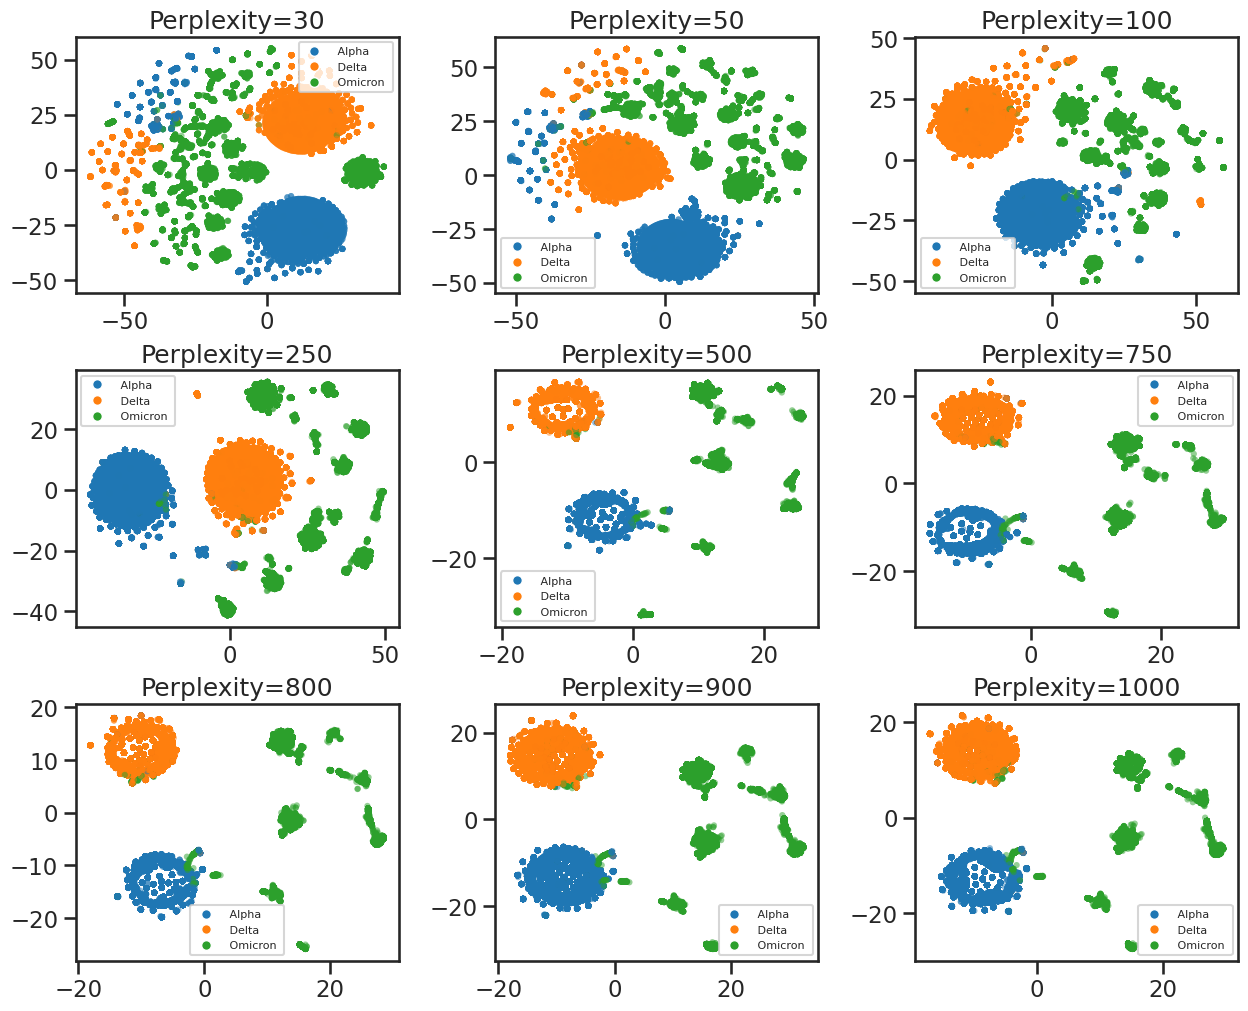

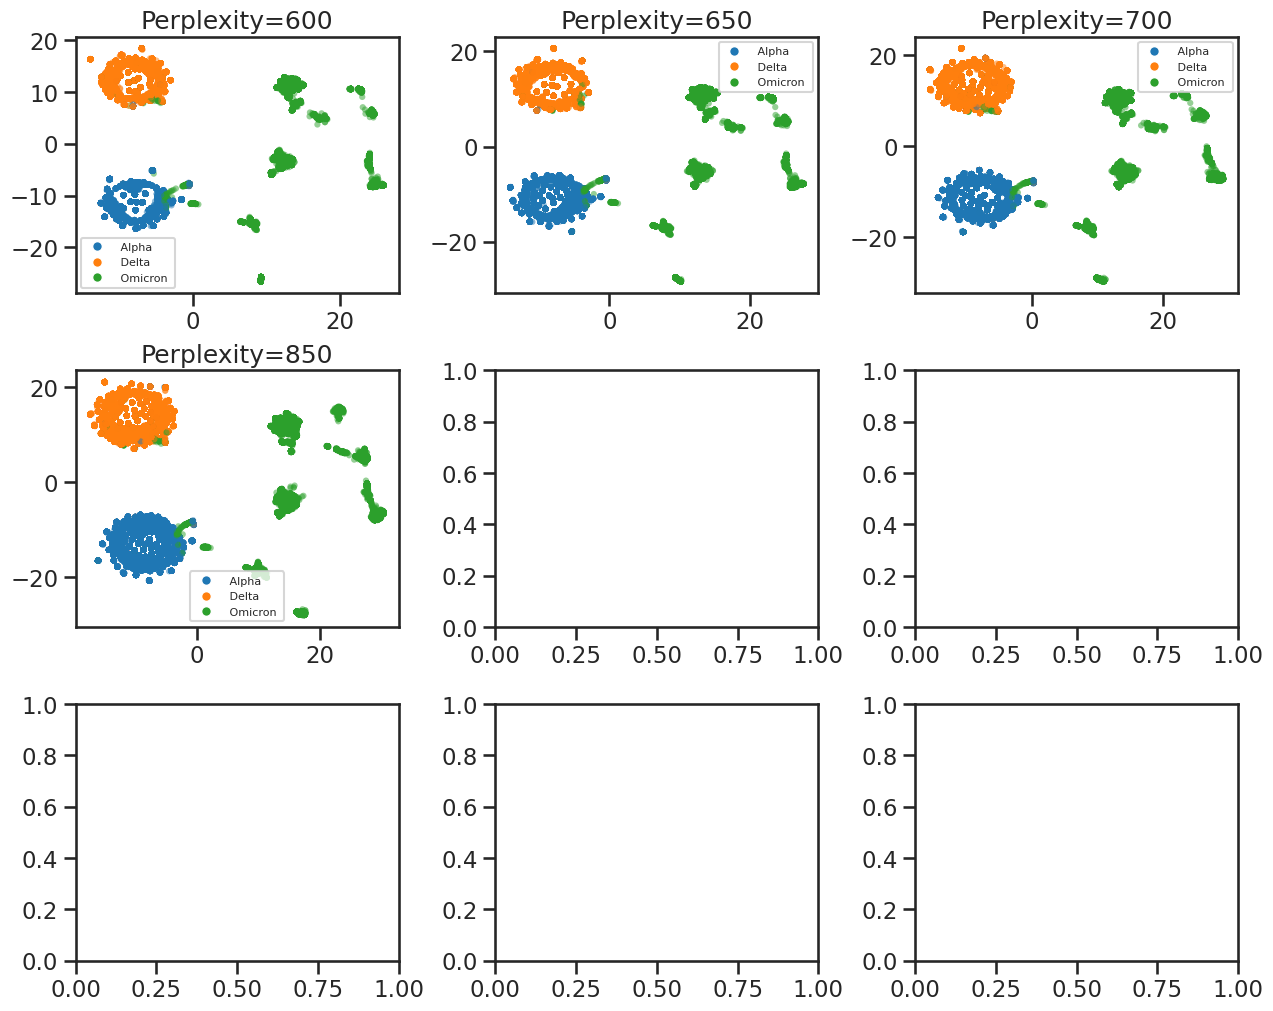

In [ ]:
import time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from openTSNE import TSNE

def plot_perplexities(npz_file, parquet_file, perp_list):
    n_rows = 3
    n_cols = 3
    sns.set_style('ticks')
    sns.set_context("talk")
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 12))
    plt.subplots_adjust(hspace=0.3, wspace=0.3)

    data_info_df = pd.read_parquet(parquet_file, engine='fastparquet')
    data = np.load(npz_file)
    X_loaded = data["X"]

    for ax, perp in zip(axes.flat, perp_list):

        start_time = time.perf_counter()

        tsne_reducer = TSNE(n_components=2, perplexity=perp, learning_rate='auto', random_state=42, n_jobs=32)
        embedding_matrix_reduced = tsne_reducer.fit(X_loaded)

        end_time = time.perf_counter()  # End timing
        elapsed = end_time - start_time
        print(f"Perplexity {perp}: Time taken = {elapsed:.2f} seconds")

        plot_df = pd.DataFrame({
            't-SNE component 1': embedding_matrix_reduced[:, 0],
            't-SNE component 2': embedding_matrix_reduced[:, 1],
            'Seq ID': data_info_df['seq_id'],
            'Variant': data_info_df['variant'],
            'Pango lineage': data_info_df['pango lineage'],
        })
        save_as = f"RBD.ADO.MSA.tSNE-perplexity{perp}.parquet"
        plot_df.to_parquet(save_as, engine='fastparquet')

        unique_variants = np.unique(plot_df['Variant'])
        variant_color_palette = sns.color_palette("tab10", n_colors=len(unique_variants)) 
        variant_color_dict = {label: color for label, color in zip(unique_variants, variant_color_palette)}
        variant_colors = [variant_color_dict[v] for v in plot_df['Variant']]

        ax.scatter(plot_df['t-SNE component 1'], plot_df['t-SNE component 2'],
                c=variant_colors, s=20, alpha=0.5, edgecolor='none', linewidth=0)
        ax.set_title(f'Perplexity={perp}')
        
        # Create per-plot legend
        handles = [
            plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=variant_color_dict[v], markersize=7)
            for v in unique_variants
        ]
        labels = unique_variants
        ax.legend(handles, labels, loc='best', fontsize=8, title_fontsize=9)

    plt.show()

plot_perplexities(
    npz_file = "msa_ado_X.compressed.npz",
    parquet_file = "msa_ado_X_info.parquet",
    perp_list = [30, 50, 100, 250, 500, 750, 800, 900, 1000]
)
plot_perplexities(
    npz_file = "msa_ado_X.compressed.npz",
    parquet_file = "msa_ado_X_info.parquet",
    perp_list = [600, 650, 700, 850]
)

Find highest or a sufficiently highest Silhouette Coefficient, Adjusted Rand Index.

min_sample 100, min_cluster_size 1000: Adjusted Rand Index: 0.33, Silhouette Coefficient: 0.27
min_sample 100, min_cluster_size 5000: Adjusted Rand Index: 0.85, Silhouette Coefficient: 0.71
min_sample 100, min_cluster_size 10000: Adjusted Rand Index: 0.85, Silhouette Coefficient: 0.71
min_sample 100, min_cluster_size 15000: Adjusted Rand Index: 0.85, Silhouette Coefficient: 0.71
min_sample 100, min_cluster_size 20000: Adjusted Rand Index: 0.56, Silhouette Coefficient: 0.44
min_sample 100, min_cluster_size 22000: Adjusted Rand Index: 0.56, Silhouette Coefficient: 0.44
min_sample 500, min_cluster_size 1000: Adjusted Rand Index: 0.21, Silhouette Coefficient: 0.29
min_sample 500, min_cluster_size 5000: Adjusted Rand Index: 0.65, Silhouette Coefficient: 0.63
min_sample 500, min_cluster_size 10000: Adjusted Rand Index: 0.72, Silhouette Coefficient: 0.64
min_sample 500, min_cluster_size 15000: Adjusted Rand Index: 0.56, Silhouette Coefficient: 0.44
min_sample 500, min_cluster_size 20000: Adju

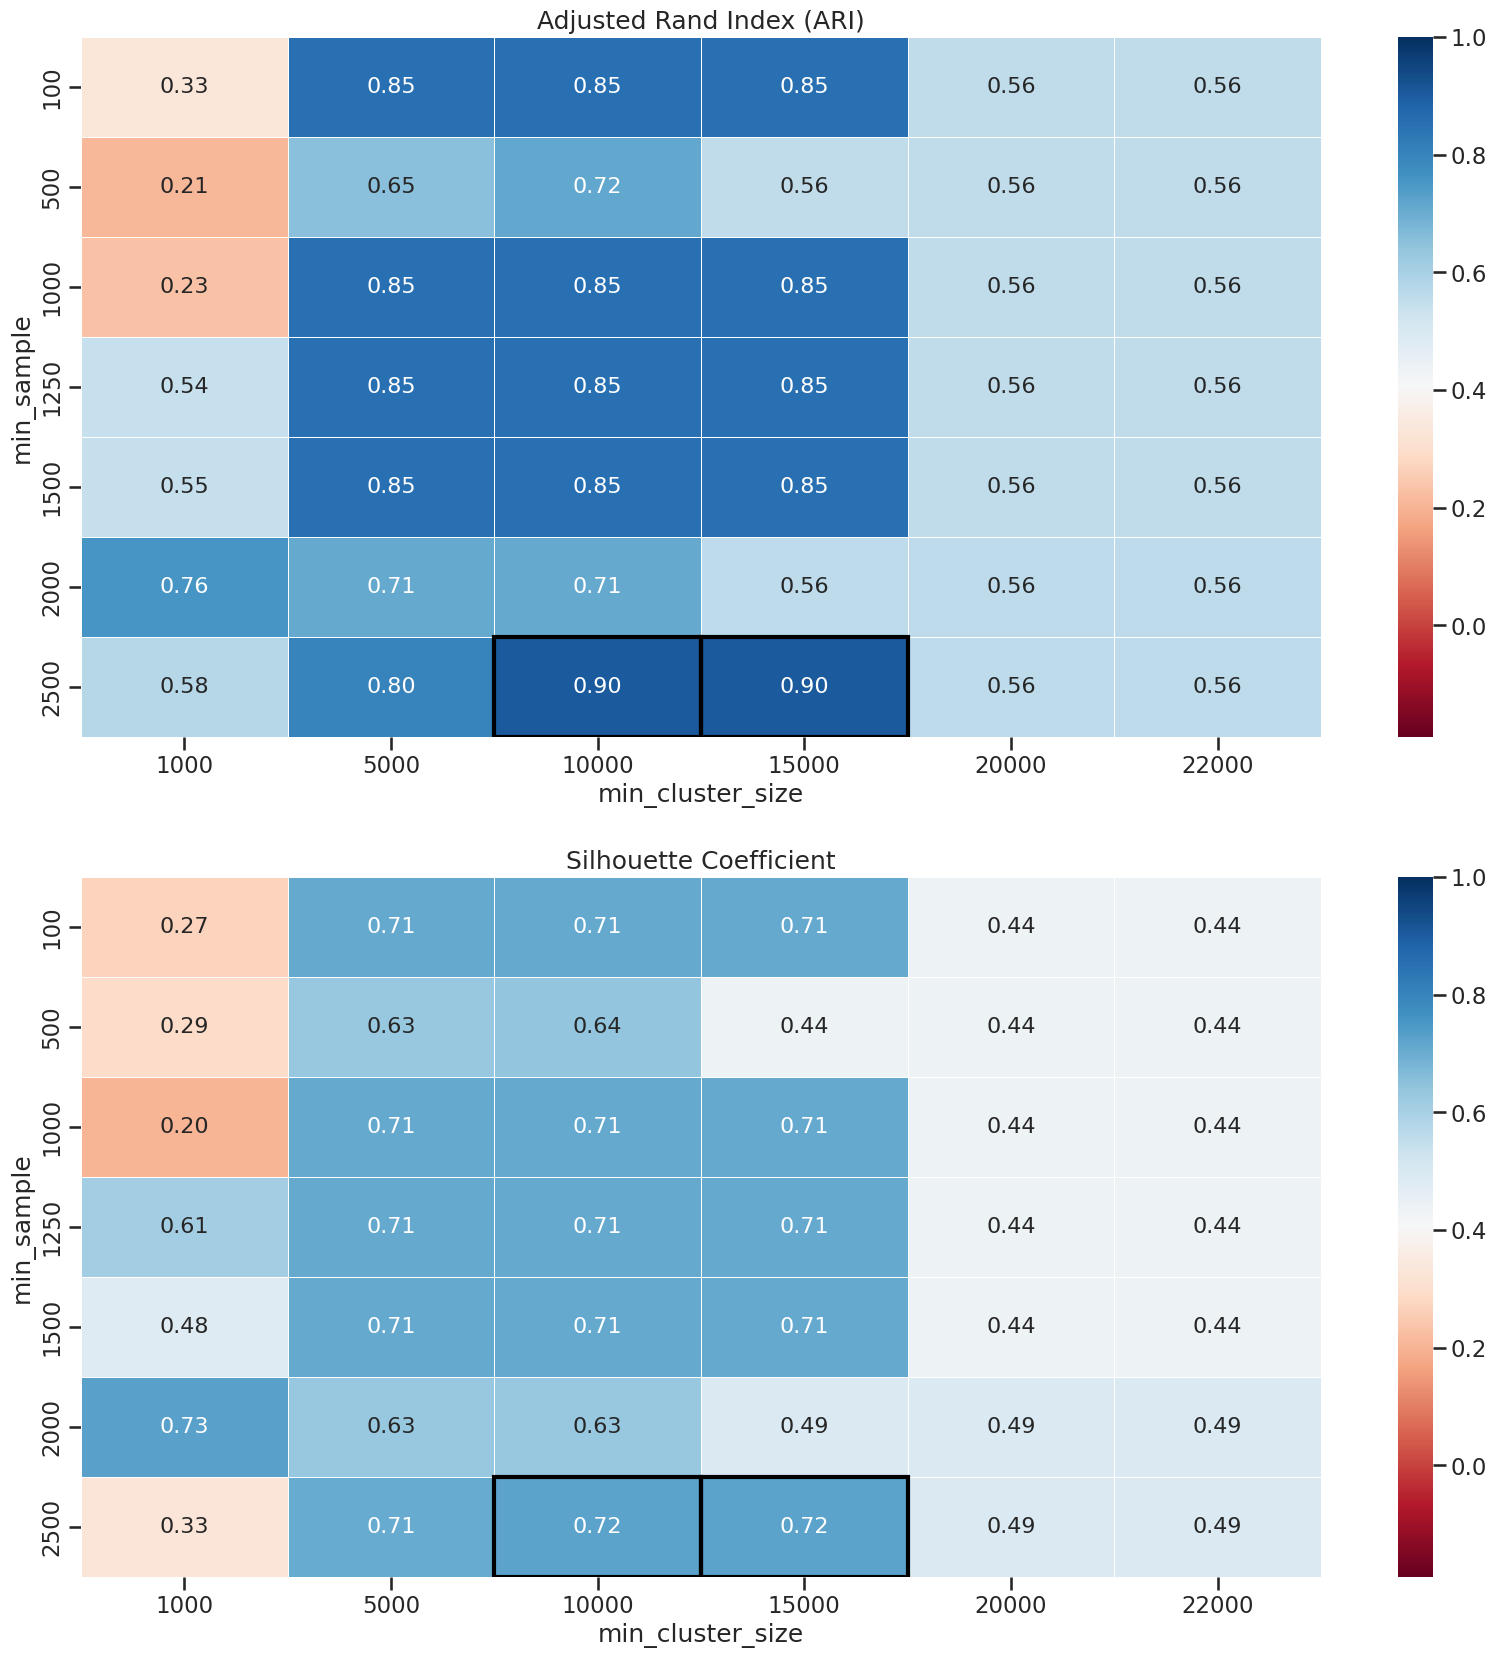

In [1]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

import hdbscan
from sklearn.metrics import silhouette_score, adjusted_rand_score
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def ari_sc_heatmap(parquet_file):
    embedded_df = pd.read_parquet(parquet_file, engine='fastparquet')
    embedding_matrix = embedded_df[['t-SNE component 1', 't-SNE component 2']].values

    results = []
    for ms in [100, 500, 1000, 1250, 1500, 2000, 2500]:
        for mcs in [1000, 5000, 10000, 15000, 20000, 22000]:
            # Cluster
            clusterer = hdbscan.HDBSCAN(
                min_samples=ms,
                min_cluster_size=mcs,
                core_dist_n_jobs=32
            ).fit(embedding_matrix)

            labels = clusterer.labels_

            # Evaluate clustering
            ari = adjusted_rand_score(embedded_df["Variant"], labels)

            # Check number of clusters (excluding noise)
            n_clusters = len(set(labels)) - (1 if -1 in labels else 0)

            if n_clusters > 1:
                silhouette_avg = silhouette_score(embedding_matrix, labels)
            else:
                silhouette_avg = np.nan  # or 0, depending on how you want to treat it

            # Store results
            results.append({
                "min_sample": ms,
                "min_cluster_size": mcs,
                "ari": ari,
                "silhouette": silhouette_avg
            })

            print(f"min_sample {ms}, min_cluster_size {mcs}: Adjusted Rand Index: {ari:.2f}, Silhouette Coefficient: {silhouette_avg:.2f}")

    # Convert to DataFrame
    df = pd.DataFrame(results)

    # Pivot matrices
    ari_matrix = df.pivot(index='min_sample', columns='min_cluster_size', values='ari')
    silhouette_matrix = df.pivot(index='min_sample', columns='min_cluster_size', values='silhouette')

    # Plot heatmaps
    sns.set_style('ticks')
    sns.set_context("talk")
    fig, axs = plt.subplots(2, 1, figsize=(20, 20))

    sns.heatmap(ari_matrix, annot=True, annot_kws={"size": 16}, fmt=".2f", linewidth=.5, cmap="RdBu", ax=axs[0], vmin=-0.19, vmax=1)
    axs[0].set_title("Adjusted Rand Index (ARI)")
    axs[0].set_xlabel("min_cluster_size")
    axs[0].set_ylabel("min_sample")

    max_ari = ari_matrix.max().max()  # Get the max ARI value

    for i in range(ari_matrix.shape[0]):  # min_sample (rows)
        for j in range(ari_matrix.shape[1]):  # min_cluster_size (cols)
            if np.isclose(ari_matrix.iloc[i, j], max_ari):  # Safe float comparison
                axs[0].add_patch(
                    plt.Rectangle((j, i), 1, 1, fill=False, edgecolor='black', lw=3)
                )

    sns.heatmap(silhouette_matrix, annot=True, annot_kws={"size": 16}, fmt=".2f", linewidth=.5, cmap="RdBu", ax=axs[1], vmin=-0.19, vmax=1)
    axs[1].set_title("Silhouette Coefficient")
    axs[1].set_xlabel("min_cluster_size")
    axs[1].set_ylabel("min_sample")

    for i in range(ari_matrix.shape[0]):  # min_sample (rows)
        for j in range(ari_matrix.shape[1]):  # min_cluster_size (cols)
            if np.isclose(ari_matrix.iloc[i, j], max_ari):  # Safe float comparison
                axs[1].add_patch(
                    plt.Rectangle((j, i), 1, 1, fill=False, edgecolor='black', lw=3)
                )
    save_as = parquet_file.replace(".parquet", ".HDBSCAN_heatmap")
    plt.savefig(f"{save_as}.pdf", format="pdf", dpi=300, bbox_inches='tight')
    plt.show()

# Load the embedding
perp = 1000
parquet_file = f"RBD.ADO.MSA.tSNE-perplexity{perp}.parquet"
ari_sc_heatmap(parquet_file)

min_sample 2500, min_cluster_size 10000: Adjusted Rand Index: 0.90, Silhouette Coefficient: 0.72


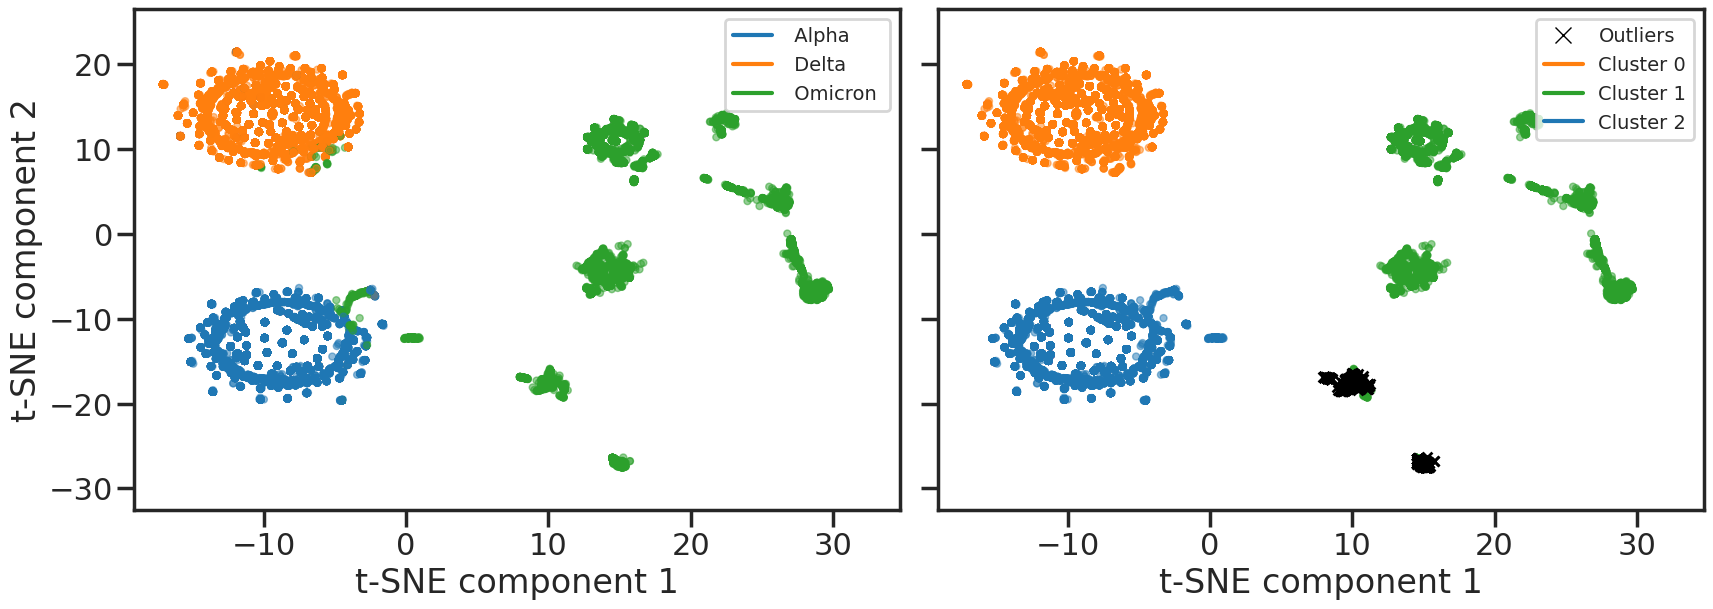

Predicted Clusters,-1,0,1,2
Ground Truth,,,,
Alpha,0.00,0.35,0.00,99.65
Delta,0.00,99.58,0.00,0.42
Omicron,15.37,0.47,82.23,1.93


In [3]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import hdbscan
from sklearn.metrics import silhouette_score, adjusted_rand_score

def get_hdbscan_values(parquet_file, min_samples, min_cluster_size):
    embedded_df = pd.read_parquet(parquet_file, engine='fastparquet')
    embedding_matrix = embedded_df[['t-SNE component 1', 't-SNE component 2']].values

    # Cluster
    hdb_labels = hdbscan.HDBSCAN(
        min_samples=min_samples,
        min_cluster_size=min_cluster_size,
        core_dist_n_jobs=-1  # Enable parallel processing
    ).fit(embedding_matrix).labels_

    # Evaluate clustering
    silhouette_avg = silhouette_score(embedding_matrix, hdb_labels)
    ari = adjusted_rand_score(embedded_df["Variant"], hdb_labels)
    print(f"min_sample {min_samples}, min_cluster_size {min_cluster_size}: Adjusted Rand Index: {ari:.2f}, Silhouette Coefficient: {silhouette_avg:.2f}")

    # Create the truth table
    truth_table_percent = pd.crosstab(embedded_df["Variant"], hdb_labels, 
                                    rownames=['Ground Truth'], 
                                    colnames=['Predicted Clusters'],
                                    normalize='index')  # Normalize along the index (rows)
    truth_table_percent = (truth_table_percent * 100).round(2)

    # Save
    plot_df = pd.DataFrame({
        't-SNE component 1': embedded_df['t-SNE component 1'],
        't-SNE component 2': embedded_df['t-SNE component 2'],
        'Cluster': hdb_labels,
        'Seq ID': embedded_df['Seq ID'],
        'Variant': embedded_df['Variant'],
        'Pango lineage': embedded_df['Pango lineage'],
    })    
    save_as = parquet_file.replace(".parquet", f".HDBSCAN-ms{min_samples}_mcs{min_cluster_size}-ari{ari:.2f}_sc{silhouette_avg:.2f}")
    plot_df.to_parquet(f"{save_as}.parquet", engine='fastparquet')
    
    return plot_df, truth_table_percent, save_as

def plot_groundtruth_prediction_1x2(plot_df, save_as, x_min_width_buffer, x_max_width_buffer, y_min_width_buffer, y_max_width_buffer, color_map, cluster_color_palette_order):
    marker_size = 25
    
    # Define a variant color palette
    unique_variants = np.unique(plot_df['Variant'])
    variant_color_palette = sns.color_palette(color_map, n_colors=len(unique_variants)) 
    variant_color_dict = {label: color for label, color in zip(unique_variants, variant_color_palette)}

    # Define a cluster color palette
    unique_clusters = np.unique(plot_df['Cluster'])
    cluster_color_palette = sns.color_palette(color_map, n_colors=10) 
    cluster_color_palette = [cluster_color_palette[i] for i in cluster_color_palette_order]
    cluster_color_dict = {label: color for label, color in zip(unique_clusters[unique_clusters != -1], cluster_color_palette)}
    cluster_color_dict[-1] = 'black'  # Set outliers to x

    sns.set_style('ticks')
    sns.set_context("poster")
    fig, axs = plt.subplots(1, 2, figsize=(20.25, 6.5), sharey=True)
    fig.subplots_adjust(wspace=0.05)  # Reduce the horizontal space between subplots

    #####################################################

    # Scatterplot
    sns.scatterplot(
        data=plot_df,
        x='t-SNE component 1', y='t-SNE component 2',
        hue='Variant', palette=variant_color_dict, 
        s=marker_size, alpha=0.5, edgecolor=None, linewidth=1,
        ax=axs[0]
    )

    # axs[0].set_title(f"Ground Truth ({len(unique_variants)} variants)", ha='center', fontweight='bold')
    axs[0].set_xlim((plot_df['t-SNE component 1'].min()-x_min_width_buffer, plot_df['t-SNE component 1'].max()+x_max_width_buffer))
    axs[0].set_ylim(plot_df['t-SNE component 2'].min()-y_min_width_buffer, plot_df['t-SNE component 2'].max()+y_max_width_buffer),

    # Legend 
    variant_handles = [
        plt.Line2D([0], [0], color=variant_color_dict[variant], label=f'{variant}')
        for variant in unique_variants
    ]
    axs[0].legend(handles=variant_handles)
    sns.move_legend(axs[0], "upper right", fontsize=14)
    
    # #####################################################

    # Scatterplot for non-outliers
    sns.scatterplot(
        data=plot_df[plot_df['Cluster'] != -1],  # Exclude outliers
        x='t-SNE component 1', y='t-SNE component 2',
        hue='Cluster', palette=cluster_color_dict, 
        s=marker_size, alpha=0.5, edgecolor=None, linewidth=1,
        ax=axs[1]
    )

    # Scatterplot for outliers (Cluster = -1)
    sns.scatterplot(
        data=plot_df[plot_df['Cluster'] == -1],  # Select only outliers
        x='t-SNE component 1', y='t-SNE component 2',
        marker='x',
        s=marker_size*2, color='black', linewidth=2,
        ax=axs[1]
    )

    # axs[1].set_title(f"Predicted ({len(unique_clusters[unique_clusters != -1])} clusters)", ha='center', fontweight='bold')
    axs[1].set_xlim((plot_df['t-SNE component 1'].min()-x_min_width_buffer, plot_df['t-SNE component 1'].max()+x_max_width_buffer))

    # Legend 
    cluster_handles = [plt.Line2D([0], [0], marker='x', color='black', linestyle='none', label='Outliers')]
    cluster_handles += [
        plt.Line2D([0], [0], color=cluster_color_dict[cluster], label=f'Cluster {cluster}')
        for cluster in unique_clusters if cluster != -1
    ]
    axs[1].legend(handles=cluster_handles)
    sns.move_legend(axs[1], "upper right", fontsize=14)

    #####################################################
  
    plt.savefig(f"{save_as}.pdf", format="pdf", dpi=300, bbox_inches='tight')
    plt.savefig(f"{save_as}.png", format="png", dpi=300, bbox_inches='tight')
    plt.show()

perp = 1000
parquet_file = f"RBD.ADO.MSA.tSNE-perplexity{perp}.parquet"

min_samples=2500
min_cluster_size=10000
plot_df, truth_table_percent, save_as = get_hdbscan_values(parquet_file, min_samples, min_cluster_size)

# Call the function
plot_groundtruth_prediction_1x2(
    plot_df, save_as, 
    x_min_width_buffer=2, x_max_width_buffer=5, y_min_width_buffer=5, y_max_width_buffer=5, 
    color_map="tab10", cluster_color_palette_order=[1, 2, 0, 3, 4, 5, 6, 7, 8, 9]
)
truth_table_percent

In [4]:
import matplotlib.dates as mdates

def cluster_pango_lineage(info_df, top_x=None):
    """ Calculate Pango lineage percentages within clusters and select top x for each cluster. """
    
    # Copy the DataFrame to avoid modifying the original
    df = info_df.copy()

    # Truncate Pango lineage to the first two parts if needed
    trunc_format = lambda x: f"{'.'.join(x.split('.')[:3])}*" if len(x.split('.')) >= 3 else x
    df['Pango lineage'] = df['Pango lineage'].apply(trunc_format)

    # Calculate lineage counts within each cluster
    cluster_counts = df.groupby(['Cluster', 'Variant', 'Pango lineage']).size().reset_index(name='Cluster count')

    # Calculate total counts for each lineage across the entire dataset
    total_counts = df.groupby('Pango lineage').size().reset_index(name='Total count')

    # Merge the cluster counts with total counts
    lineage_counts = pd.merge(cluster_counts, total_counts, on='Pango lineage', how='left')

    # Calculate the 'Cluster %' and 'Lineage %'
    lineage_counts['Cluster %'] = (lineage_counts['Cluster count'] / lineage_counts.groupby('Cluster')['Cluster count'].transform('sum')) * 100
    lineage_counts['Lineage %'] = (lineage_counts['Cluster count'] / lineage_counts['Total count']) * 100

    # Sort by 'cluster' and then by 'Cluster %' within each cluster
    lineage_counts = lineage_counts.sort_values(by=['Cluster', 'Cluster %'], ascending=[True, False])
    lineage_counts = lineage_counts.drop(columns=['Cluster count', 'Total count'])

    # Select top x lineages for each cluster
    if top_x != None:
        top_lineages_per_cluster = lineage_counts.groupby('Cluster').head(top_x)
        return top_lineages_per_cluster.reset_index(drop=True)
    else:
        return lineage_counts.reset_index(drop=True)

def split_dataframe_by_cluster(df):
    """ Split the DataFrame into separate DataFrames by cluster. """
    
    # Create a dictionary to store DataFrames for each cluster
    cluster_dfs = {}
    
    # Group the DataFrame by 'cluster' and iterate over each group
    for cluster, group in df.groupby('Cluster'):
        # Store each group as a separate DataFrame in the dictionary
        cluster_dfs[cluster] = group.reset_index(drop=True)
    
    return cluster_dfs

# Cluster info
result = cluster_pango_lineage(plot_df, 5)

clusters = result['Cluster'].unique()
clustered_dataframes = split_dataframe_by_cluster(result)

for cluster in clusters:
    print(f"{clustered_dataframes[cluster]}\n")

   Cluster    Variant Pango lineage  Cluster %  Lineage %
0       -1   Omicron        BA.1.1*  43.854996  84.497445
1       -1   Omicron           BA.1  19.451813  89.189189
2       -1   Omicron       BA.1.17*  12.378426  96.774194
3       -1   Omicron       BA.1.15*  11.612143  91.841492
4       -1   Omicron       BA.1.18*   2.505158  94.444444

   Cluster  Variant Pango lineage  Cluster %  Lineage %
0        0   Delta           AY.4  13.030727  99.861687
1        0   Delta       B.1.617*   7.174119  99.065421
2        0   Delta         AY.122   6.407075  98.679639
3        0   Delta         AY.103   5.563326  99.355359
4        0   Delta          AY.43   4.642873  99.420290

   Cluster    Variant Pango lineage  Cluster %  Lineage %
0        1   Omicron        BA.5.2*  11.464301  99.000951
1        1   Omicron           BA.2  10.076025  94.278351
2        1   Omicron        BQ.1.1*   7.828338  99.579537
3        1   Omicron       XBB.1.5*   6.528206  99.747475
4        1   Omicron    

---

In [9]:
perp = 1000
parquet_file = f"RBD.ADO.MSA.tSNE-perplexity{perp}.parquet"

min_samples=2500
min_cluster_size=10000
plot_df, truth_table_percent, save_as = get_hdbscan_values(parquet_file, min_samples, min_cluster_size)
plot_df.loc[:, "Variant"] = plot_df["Variant"].str.strip()
plot_df

min_sample 2500, min_cluster_size 10000: Adjusted Rand Index: 0.90, Silhouette Coefficient: 0.72


,t-SNE component 1,t-SNE component 2,Cluster,Seq ID,Variant,Pango lineage
0,15.553745,10.345704,1,EPI_ISL_16604644,Omicron,DY.1
1,15.129680,10.013284,1,EPI_ISL_14904955,Omicron,BA.5.5
2,14.758980,10.900569,1,EPI_ISL_14057608,Omicron,BA.4.1
3,14.758980,10.900569,1,EPI_ISL_14905668,Omicron,BE.3
4,14.758980,10.900569,1,EPI_ISL_14903173,Omicron,BF.5
...,...,...,...,...,...,...
66220,11.026179,-19.232517,1,EPI_ISL_10882618,Omicron,BA.1.15
66221,11.033587,-19.232520,1,EPI_ISL_11376320,Omicron,BA.1
66222,11.033587,-19.232520,1,EPI_ISL_11376330,Omicron,BA.1.14.1
66223,11.034630,-19.234297,1,EPI_ISL_9588086,Omicron,BA.1


In [11]:
# Cluster 2
cluster_alpha = plot_df[plot_df["Cluster"] == 2]
print(cluster_alpha["Variant"].value_counts())

# Save
save_as = f"RBD.ADO.MSA.tSNE-perplexity{perp}.cluster2"
cluster_alpha.to_csv(f"{save_as}.csv", index=False)

Variant
Alpha      21997
Omicron      427
Delta         93
Name: count, dtype: int64


In [12]:
# Cluster 0
cluster_delta = plot_df[plot_df["Cluster"] == 0]
print(cluster_delta["Variant"].value_counts())

# Save
save_as = f"RBD.ADO.MSA.tSNE-perplexity{perp}.cluster0"
cluster_delta.to_csv(f"{save_as}.csv", index=False)

Variant
Delta      21982
Omicron      103
Alpha         78
Name: count, dtype: int64


In [13]:
# Cluster 1
cluster_omicron = plot_df[plot_df["Cluster"] == 1]
print(cluster_omicron["Variant"].value_counts())

# Save
save_as = f"RBD.ADO.MSA.tSNE-perplexity{perp}.cluster1"
cluster_omicron.to_csv(f"{save_as}.csv", index=False)

Variant
Omicron    18152
Name: count, dtype: int64
